This has nothing to do with the particular OAP application

If the OAP was cut with an offset and clocking angle that deviate from the design, it leads to different mechanical mounting parameters than as designed.

The question we are trying to answer:

We assume Nu-Tek measured the radius of curvature perfectly.
Given that Nu-Tek cut the OAP at an unknown (offset, clocking_angle), we had to do translations and tilts to get back the almost perfect surface, can we reverse solve the problem and derive the offset and clocking_angle?

Executive summary:

yes, the code below does the above. But the RMS error still seems to be large (~119 microns).
The problem may be that there can be large uncertains in the translations and tilts that we determined, for example, the thickness and uniformity of the double-sided tape?

In [881]:
import numpy as np
import matplotlib.pyplot as plt
plt.jet();

<Figure size 432x288 with 0 Axes>

In [882]:
#everything in this cell is OAP1 specific
oapR = 628.99 #OAP1, measured by NuTek
oapBeamD = oapR/2/222*6.949 #mm, 6.949mm is FOV width of PhaseCam
pixelSize = 0.1 #mm
offset0 = 60
clocking0 = 180

print(oapBeamD)

#we measured the following in the lab
#+z points to FM2
#+y points up from bench
#+x points to OAP2 (according to RH rule)
#if they cut with an offset a little too large, 
#.   the part of surface we need will be closer to the innner edge than it should be
#.   then we have to shift the mirror mount outward in order to use the same part of the surface.
lab_x = 0.114 #mm, need to increase offset by this much; test: set to 5, min will be at x=-65mm
lab_y = 1.26 #mm, clocking angle goes beyond 180° a little; test: set to 10, min will be at y = -10mm
lab_h = -0.346 #deg, negative means outer part gets closer to center of curvature; 
            # test: set to -2 (with lab_z = 1), min will be at x=-54mm
lab_v = 0.091 #deg, positive means lower parts gets closer to the center of curvature; 
            # test: set to 2, min will be at y = +10mm
lab_z = 2.801 #mm, positive means this needs to be moved closer to the center of curvature;
            # test: set to 1, min will be at x=-54mm

lab_x = -lab_x #in our coordinate below, larger offset means x becomes more negative
lab_y = -lab_y #in our coordinate below, larger offset means y becomes more negative
lab_v = -lab_v #in our coordinate below, larger vertical angle means -y -->+z

9.844260157657658


In [883]:
map_min = -100 #mm
map_max = 100 #mm
nPixel = int((map_max - map_min)/pixelSize)
xVec = np.linspace(map_min, map_max, nPixel+1)
yVec = np.linspace(map_min, map_max, nPixel+1)
[x, y] = np.meshgrid(xVec, yVec)

r2 = (x**2+y**2)
z= -1/oapR*r2
z[r2>map_max**2] = np.nan

In [884]:
#plt.imshow(z, extent=[map_min, map_max, map_min, map_max])
#plt.xlabel('mm')
#plt.ylabel('mm')
#plt.colorbar()

In [885]:
def cutout(offset, clocking, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, lab_z):
    #these are the offsets with which we cut out the big piece, which goes into the mirror mount
    offsetxMount = offset*np.cos(np.radians(clocking))
    offsetyMount = offset*np.sin(np.radians(clocking))
    
    #for surface comparison, we only cut out D=beam size.
    offsetx = offsetxMount - lab_x
    offsety = offsetyMount - lab_y
    offsetx = np.round(offsetx/pixelSize)*pixelSize #without rounding, number of pixels will mismatch
    offsety = np.round(offsety/pixelSize)*pixelSize
    idx = ((x-offsetx)**2 + (y-offsety)**2 < (oapBeamD/2)**2)
    zcutout = z[idx]
    xcutout = x[idx]
    ycutout = y[idx]

    zcutout -= (xcutout-offsetx)*np.tan(np.radians(lab_h))
    zcutout -= (ycutout-offsety)*np.tan(np.radians(lab_v))
    zcutout -= lab_z

    
    return offsetxMount, offsetyMount, xcutout, ycutout, zcutout

In [886]:
offsetx, offsety, xcutout, ycutout, zcutout0 = cutout(offset0, clocking0, x, y, z, oapBeamD,0,0,0,0,0)
plt_min = np.min(np.abs(zcutout0))
plt_max = np.max(np.abs(zcutout0))
#plt.scatter(xcutout, ycutout, np.abs(zcutout0), np.abs(zcutout0), vmin=plt_min, vmax=plt_max)
#plt.colorbar()

#print(zcutout0[1000])
offsetArray = np.arange(40,46,0.2)
clockingArray = np.arange(170, 190.1, 2)
offsetxArray = np.zeros(len(offsetArray)*len(clockingArray))
offsetyArray = np.zeros(len(offsetArray)*len(clockingArray))
rmsArray = np.zeros(len(offsetArray)*len(clockingArray))
i = 0
#fig, ax = plt.subplots(1,10, figsize=(20,2))
for offset in offsetArray:
    for clocking in clockingArray:
        offsetx, offsety, xcutout, ycutout, zcutout = cutout(offset, clocking, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, lab_z)
        offsetxArray[i] = offsetx
        offsetyArray[i] = offsety
        rmsArray[i] = np.sqrt(np.mean((zcutout - zcutout0)**2))
        i+=1
        #if i<5:
        #    print(xcutout[-1], zcutout[-1], zcutout0[-1], rmsArray[i-1])
        # ax[i-1].scatter(xcutout, ycutout, np.abs(zcutout), np.abs(zcutout), vmin=plt_min, vmax=plt_max)
        #print('%5.1f, %5.1f %.3f'%(offsetx, offsety, np.std(zcutout - zcutout0)))

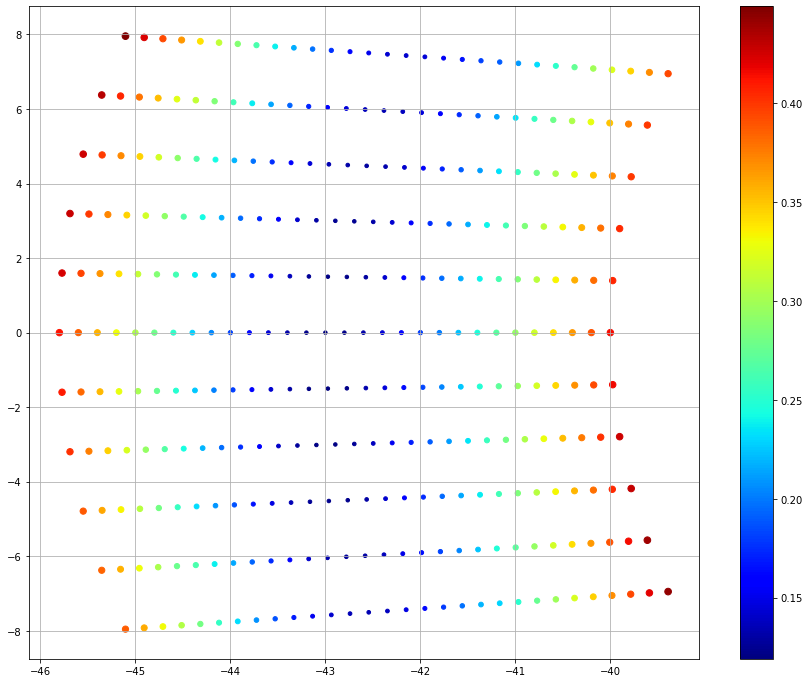

In [887]:
fig, ax = plt.subplots(1,1, figsize=(15,12))
plt.scatter(offsetxArray, offsetyArray, rmsArray*100, rmsArray)
plt.grid()
plt.colorbar()

In [888]:
np.min(rmsArray)

0.11914689734545181

In [889]:
idxmin = rmsArray == np.min(rmsArray)

In [891]:
offsetxArray[idxmin], offsetyArray[idxmin]

(array([-42.97380556]), array([-1.50067836]))

### Let's use fmin() to minimize the \chi^2

In [893]:
from scipy import optimize

In [896]:
def cutoutChi2(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, lab_z, zcutout0):
    offset = cutParam[0]
    clocking = cutParam[1]
    offsetx, offsety, xcutout, ycutout, zcutout = cutout(offset, clocking, x, y, z, oapBeamD, 
                                                         lab_x, lab_y, lab_h, lab_v, lab_z)
    return np.mean((zcutout - zcutout0)**2)

In [934]:
xopt = optimize.fmin(
    lambda cutParam: cutoutChi2(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, lab_z, zcutout0),
    [-45, -1], disp=1)

offset_min = xopt[0]
clocking_min = xopt[1]
rms = np.sqrt(cutoutChi2(xopt, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, lab_z, zcutout0))
print('offset from parent center = %.1f mm'%offset_min)
print('OAP clocking = %.2f deg'%clocking_min)
print('surface RMS error = %d microns'%(rms*1000))

Optimization terminated successfully.
         Current function value: 0.014389
         Iterations: 19
         Function evaluations: 57
offset from parent center = -43.0 mm
OAP clocking = -1.02 deg
surface RMS error = 119 microns


In [935]:
def cutoutChi2_zfloat(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, zcutout0):
    offset = cutParam[0]
    clocking = cutParam[1]
    lab_z = cutParam[2]
    offsetx, offsety, xcutout, ycutout, zcutout = cutout(offset, clocking, x, y, z, oapBeamD, 
                                                         lab_x, lab_y, lab_h, lab_v, lab_z)
    if lab_z > 3.3 or lab_z < 2.5:
        zcutout += 1e10
    return np.mean((zcutout - zcutout0)**2)

In [938]:
xopt = optimize.fmin(
    lambda cutParam: cutoutChi2_zfloat(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, zcutout0),
    [-45, -1, 2.8], disp=1)

offset_min = xopt[0]
clocking_min = xopt[1]
lab_z_min = xopt[2]
rms = np.sqrt(cutoutChi2_zfloat(xopt, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, zcutout0))
print('offset from parent center = %.1f mm'%offset_min)
print('OAP clocking = %.2f deg'%clocking_min)
print('OAP z translation = %.2f mm'%lab_z_min)
print('surface RMS error = %d microns'%(rms*1000))

Optimization terminated successfully.
         Current function value: 0.010679
         Iterations: 69
         Function evaluations: 130
offset from parent center = -45.2 mm
OAP clocking = -1.12 deg
OAP z translation = 2.50 mm
surface RMS error = 103 microns


In [957]:
def cutoutChi2_hfloat(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_v, lab_z, zcutout0):
    offset = cutParam[0]
    clocking = cutParam[1]
    lab_h = cutParam[2]
    offsetx, offsety, xcutout, ycutout, zcutout = cutout(offset, clocking, x, y, z, oapBeamD, 
                                                         lab_x, lab_y, lab_h, lab_v, lab_z)
    if lab_h > 0 or lab_h < -5:
        zcutout += 1e10
    return np.mean((zcutout - zcutout0)**2)

In [958]:
xopt = optimize.fmin(
    lambda cutParam: cutoutChi2_hfloat(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_v, lab_z, zcutout0),
    [-45, -1, -.346], disp=1)

offset_min = xopt[0]
clocking_min = xopt[1]
lab_h_min = xopt[2]
rms = np.sqrt(cutoutChi2_hfloat(xopt, x, y, z, oapBeamD, lab_x, lab_y, lab_v, lab_z, zcutout0))
print('offset from parent center = %.1f mm'%offset_min)
print('OAP clocking = %.2f deg'%clocking_min)
print('OAP H tilt = %.2f deg'%lab_h_min)
print('surface RMS error = %d microns'%(rms*1000))

Optimization terminated successfully.
         Current function value: 0.001022
         Iterations: 139
         Function evaluations: 273
offset from parent center = -43.2 mm
OAP clocking = 6.12 deg
OAP H tilt = -2.91 deg
surface RMS error = 31 microns


In [947]:
lab_h

-0.346

In [902]:
def cutoutChi2_allfloat(cutParam, x, y, z, oapBeamD, zcutout0):
    offset = cutParam[0]
    clocking = cutParam[1]
    lab_z = cutParam[2]
    lab_x = cutParam[3] 
    lab_y = cutParam[4] 
    lab_h = cutParam[5]
    lab_v = cutParam[6]
    offsetx, offsety, xcutout, ycutout, zcutout = cutout(offset, clocking, x, y, z, oapBeamD, 
                                                         lab_x, lab_y, lab_h, lab_v, lab_z)
    return np.mean((zcutout - zcutout0)**2)

In [937]:
xopt = optimize.fmin(
    lambda cutParam: cutoutChi2_allfloat(cutParam, x, y, z, oapBeamD, zcutout0),
    [-45, 0, 0, 0, 0, 0, 0], disp=1)

offset_min = xopt[0]
clocking_min = xopt[1]
lab_z_min = xopt[2]
rms = cutoutChi2_allfloat(xopt, x, y, z, oapBeamD, zcutout0)
print('offset from parent center = %.1f mm'%offset_min)
print('OAP clocking = %.2f deg'%clocking_min)
print('surface RMS error = %d microns'%(rms*1000))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 753
         Function evaluations: 1209
offset from parent center = -60.0 mm
OAP clocking = -0.00 deg
surface RMS error = 0 microns


### Below are experimental features; Ignore for now!

In [920]:
xopt = optimize.minimize(
    lambda cutParam: cutoutChi2_zfloat(cutParam, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, zcutout0), (-60, 0, 2),
    bounds = ((-100, -30), (-10, 0), (2, 3.5)), tol=1.e-16)

print(xopt.message)
offset_min = xopt.x[0]
clocking_min = xopt.x[1]
lab_z_min = xopt.x[2]
rms = cutoutChi2_zfloat(xopt.x, x, y, z, oapBeamD, lab_x, lab_y, lab_h, lab_v, zcutout0)
print(offset_min, clocking_min, lab_z_min, rms)

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
-60.0 0.0 2.0 3.935003852955892


In [913]:
xopt

      fun: 3.935003852955892
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        , -0.        ,  3.96724913])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-60.,   0.,   2.])